## Section 2: Model checking
In this section, we will look at two techniques that aim to answer:
1. Are the model and parameters estimated a good fit for the underlying data?
2. Given two separate models, which is a better fit for the underlying data?

----

### Model Check I: Posterior predictive check
One method of checking model fit is called the posterior predictive check. I find this to be a very intuitive technique. You'll recall in the previous section we estimated the parameter $\mu$ of a Poisson distribution by collecting 200,000 samples from the posterior distribution of $\mu$. Each of these samples was considered to be a credible parameter value.

The posterior predictive check requires one to generate new data from the predicted model. What does that mean? Well, we have estimated 200,000 credible values of $\mu$ for the Poisson distribution. That means we can construct 200,000 Poisson distributions with these values and then randomly sample from these distributions. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Conceptually, if the model is a good fit for the underlying data - then the generated data should resemble the original observed data. PyMC provides a convenient way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

This is almost identical to `y_est` except we do not specify the observed data. PyMC considers this to be a stochastic node (as opposed to an observed node) and as the MCMC sampler runs - it also samples data from `y_est`.

We then plot `y_pred` below and compare it to the observed data `y_est`

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from IPython.display import Image

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

In [2]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 63.5 sec

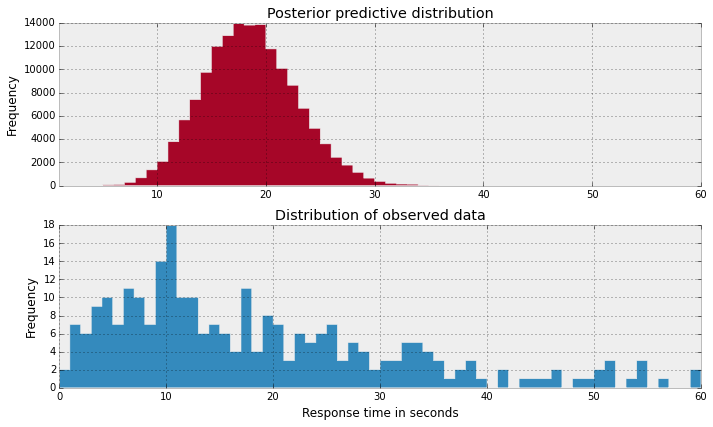

In [3]:
x_lim = 60
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Choosing the right distribution
I'm not particularly happy with the above plot. Ideally, I'd like the posterior predictive distribution to somewhat resemble the distribution of the observed data. Intuitively, if we have correctly estimated the parameters of the model, then we should be able to sample similar data from that model. Clearly this is not the case.

Perhaps the Poisson distribution is not suitable for this data. One alternative option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. Recall that the Poisson distribution has one parameter ($\mu$) that represents both its mean and its variance.

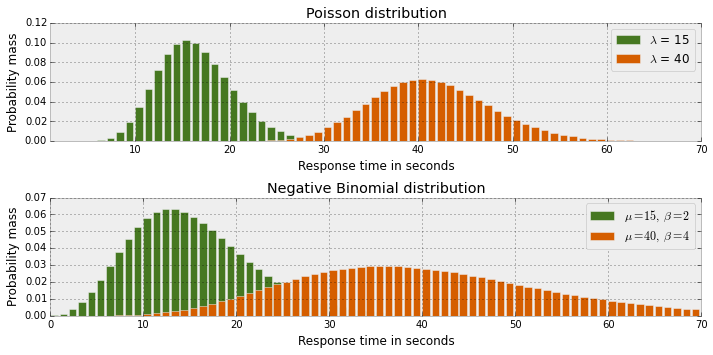

In [4]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1])])

plt.tight_layout()

Lets go ahead and estimate the parameters for a Negative Binomial distribution given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$y_{j} \sim NegBinomial(\mu, \alpha)$$
$$\alpha = Exponential(0.2)$$
$$\mu = Uniform(0,100)$$

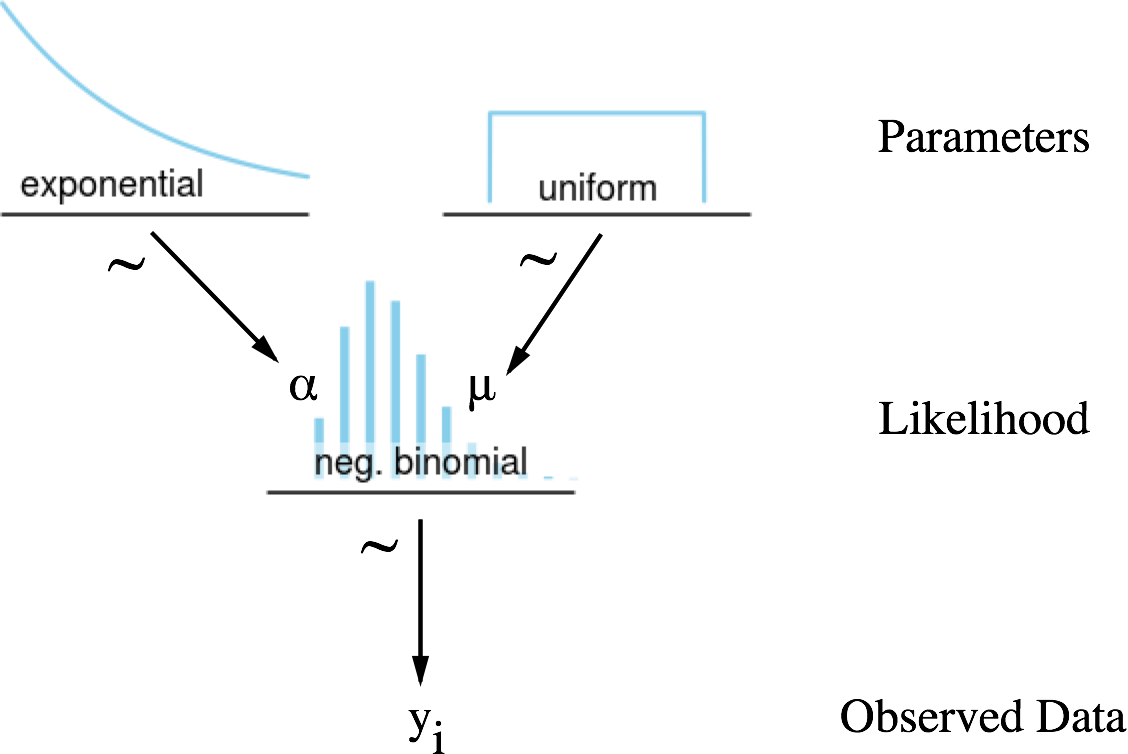

In [5]:
Image('graphics/Neg Binomial Dag.png', width=400)

In [6]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 114.8 sec

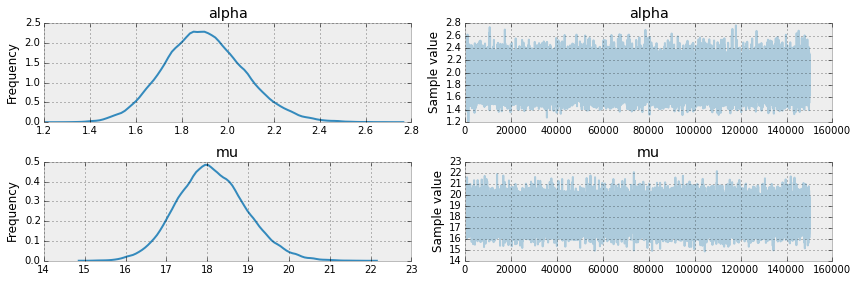

In [7]:
_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

We see the above model has greater uncertainty around the estimation of the mean response time $(\mu)$ for chat messages:
- Poisson: 17.5 to 18.5
- Negative Binomial: 16 to 21

Additionally, the Negative Binonomial model has an $\alpha$ parameter of 1.4 to 2.4 which further increases the variance in the estimated parameter $\mu$. Let's have a look at the posterior preditive distribution and see if it more closely resembles the distribution from the observed data.

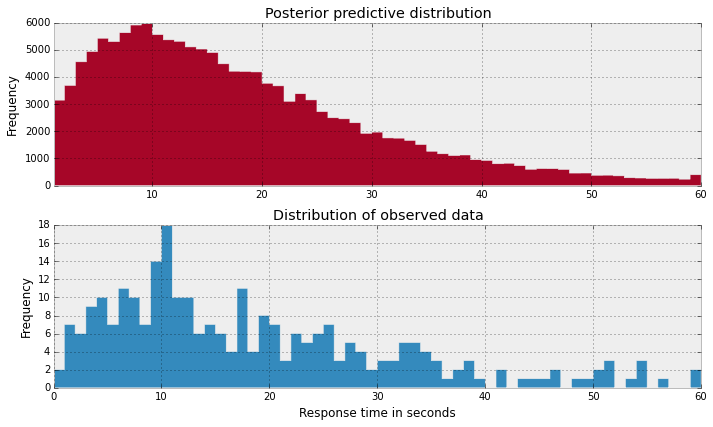

In [8]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Yes, these two distributions are looking more similar to one another. As per the posterior predictive check, this would suggest that the Negative binomial model is a more appropriate fit for the underlying data. 

If you find yourself doubting the rigor of this model checking approach, Bayesians have other, more analytical methods. 

### Model Check II: Bayes Factor
Another modeling technique is to compute the Bayes factor. This is an analytical method that aims to compare two models with each other.

The Bayes factor was typically a difficult metric to compute because it required integrating over the full joint probability distribution. In a low dimension space, integration is possible but once you begin to model in even modest dimensionality, integrating over the full joint posterior distribution becomes computationally costly and time-consuming.

There is an alternative and analogous technique for calculating the Bayes factor. It involves taking your two models for comparison and combining them into a hierarchical model with a model parameter index ($\tau$). This index will switch between the two models throughout the MCMC process depending on which model it finds more credible. As such, the trace of the model index tells us a lot about the credibility of model M1 over model M2.

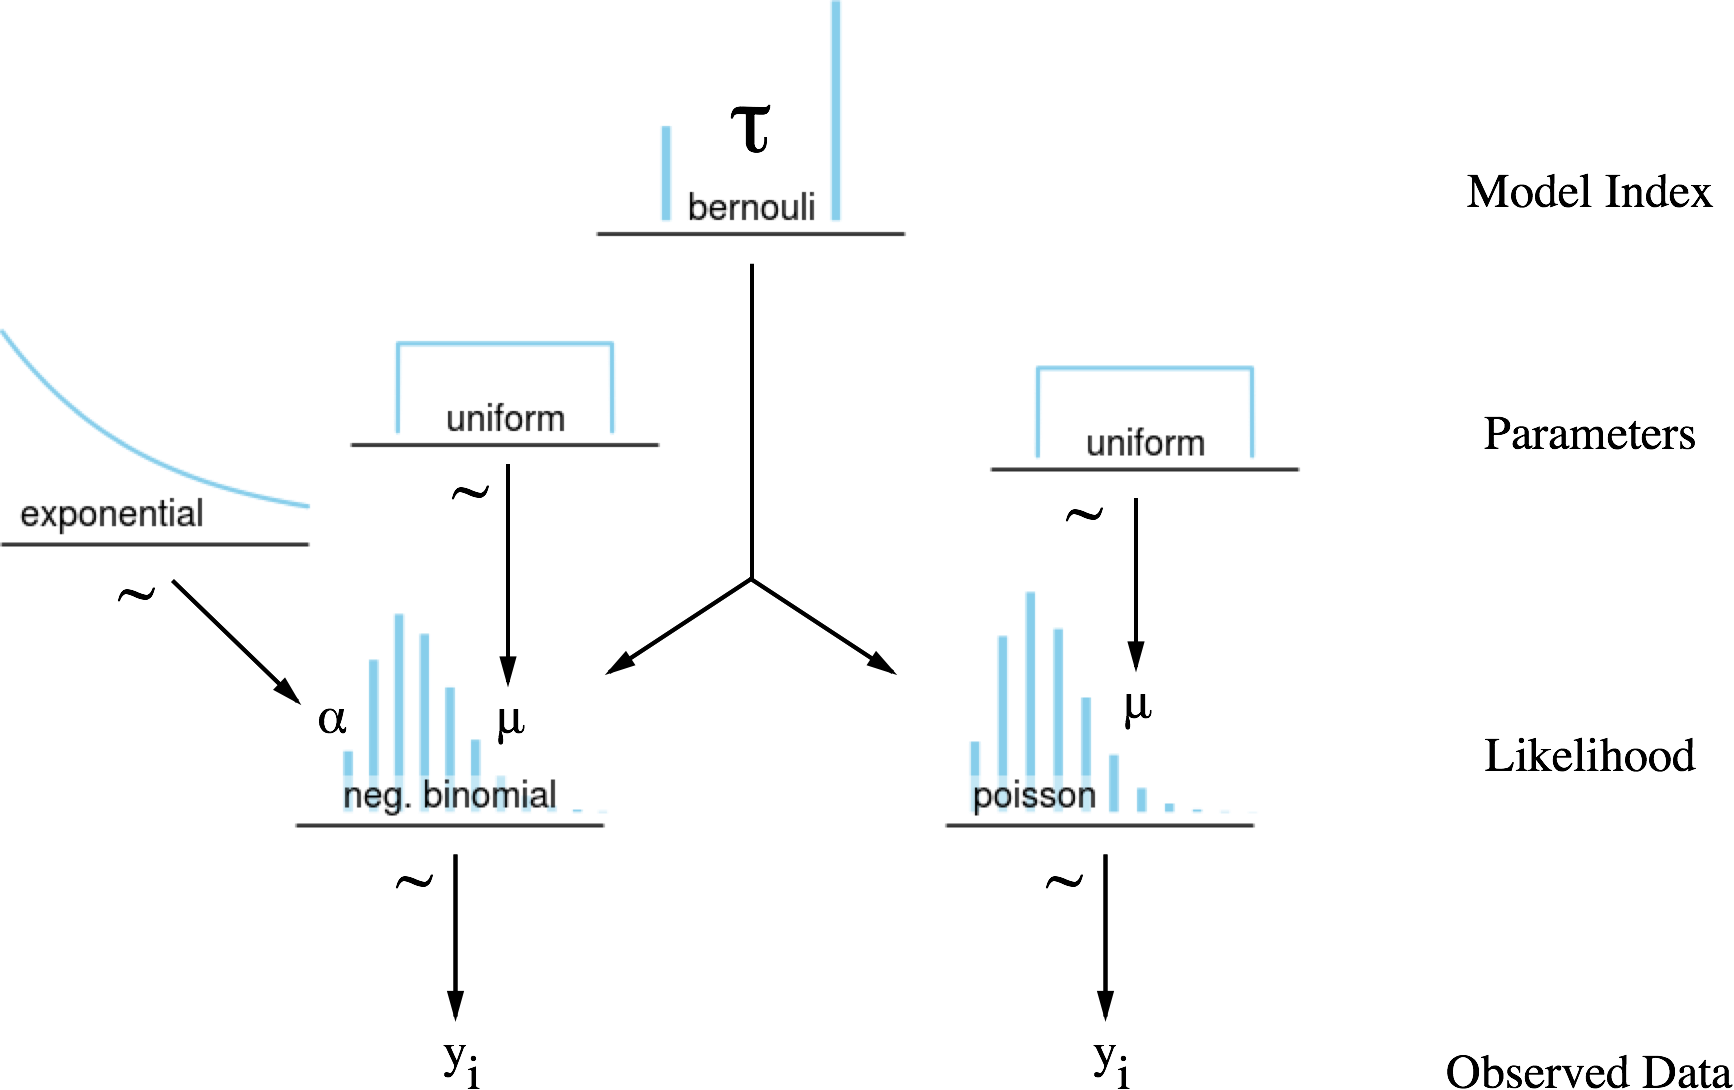

In [9]:
Image('graphics/Bayes Factor DAG.png', width=540)

Applied interval-transform to mu_p and added transformed mu_p_interval to model.
Applied log-transform to alpha and added transformed alpha_log to model.
Applied interval-transform to mu_nb and added transformed mu_nb_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 314.6 sec

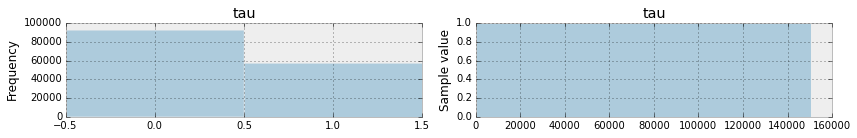

In [10]:
with pm.Model() as model:
    
    # Index to true model
    prior_model_prob = 0.5
    #tau = pm.DiscreteUniform('tau', lower=0, upper=1)
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 60)

    # Negative Binomial parameters
    alpha = pm.Exponential('alpha', lam=0.2)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=60)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.switch(tau, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategoricalStep(vars=[tau], values=[0,1])
    trace = pm.sample(200000, step=[step1, step2], start=start)

_ = pm.traceplot(trace[burnin:], varnames=['tau'])

We can calculate the Bayes Factor for the above two models using the below formulation:

$$Posterior Odds = Bayes Factor * Prior Odds$$

$$\frac{P(Data \ | \ M_{1})}{P(Data \ | \ M_{2})} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$

In the above example, we didn't apply prior probability to either model, hence the Bayes Factor is simply the quotient of the model likelihoods. If you find that your MCMC sampler is not traversing between the two models, you can introduce prior probabilities that will help you get sufficient exposure to both models.

In [12]:
# Compute the Bayes factor
prob_pois = trace[burnin:]['tau'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
print("Bayes Factor: %s" % BF)

Bayes Factor: 1.60114103387


A Bayes Factor of >1 suggests that $M_1$ (Negative Binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.60 as there being weak evidence of $M_1$ over $M_2$ given the data. Combining the posterior predictive check and Bayes factor I will conclude that the Negative Binomial is a better model for the given data.

| Bayes Factor                            | Interpretation                      |
|-----------------------------------------|-------------------------------------|
| BF($M_1, M_2$) < 1/10       | Strong evidence for $M_2$   |
| 1/10 < BF($M_1, M_2$),< 1/3 | Moderate evidence for $M_2$ |
| 1/3 < BF($M_1, M_2$) < 1    | Weak evidence for $M_2$     |
| 1 < BF($M_1, M_2$) < 3      | Weak evidence for $M_1$     |
| 3 < BF($M_1, M_2$) < 10     | Moderate evidence for $M_1$ |
| BF($M_1, M_2$) > 10         | Strong evidence for $M_1$   |

#### [>> Go to the Next Section](http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb)

### References
1. Jeffreys' scale of evidence, Humboldt University of Berlin. [Link](http://fedc.wiwi.hu-berlin.de/xplore/ebooks/html/csa/node124.html)
2. Model checking and diagnostics, PyMC2 Documentation. [Link](https://pymc-devs.github.io/pymc/modelchecking.html)
3. Compute Bayes factor using PyMC3, Chris Fonnesbeck. [GitHub Issue](https://github.com/pymc-devs/pymc3/issues/812)
4. [Doing Bayesian Data Analysis](http://www.amazon.com/Doing-Bayesian-Analysis-Second-Edition/dp/0124058884/ref=dp_ob_title_bk) by John Kruschke

In [13]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()